In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import matplotlib.pyplot as plt
from collections import namedtuple
from IPython.display import clear_output
from statistics import mean

In [2]:
class Actor_critic(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_layer=64):
        super(Actor_critic, self).__init__()
        
        self.critic_net = nn.Sequential(
            nn.Linear(in_dim, hidden_layer),
            nn.Tanh(),
            nn.Linear(hidden_layer, hidden_layer),
            nn.Tanh(),
            nn.Linear(hidden_layer, 1)
        )
        
        self.actor_net = nn.Sequential(
            nn.Linear(in_dim, hidden_layer),
            nn.Tanh(),
            nn.Linear(hidden_layer, hidden_layer),
            nn.Tanh(),
            nn.Linear(hidden_layer, out_dim),
            nn.Softmax()
        )
    
    def forward(self, x):
        value = self.critic_net(x)
        probs = self.actor_net(x)
        
        return Categorical(probs), value

In [3]:
def smooth_plot(factor, item, plot_decay):
    item_x = np.arange(len(item))
    item_smooth = [np.mean(item[i:i+factor]) if i > factor else np.mean(item[0:i+1])
                  for i in range(len(item))]
    for i in range(len(item)// plot_decay):
        item_x = item_x[::2]
        item_smooth = item_smooth[::2]
    return item_x, item_smooth
    
def plot(episode, rewards, losses, episode_steps):
    clear_output(True)
    rewards_x, rewards_smooth = smooth_plot(10, rewards, 1000)
    losses_x, losses_smooth = smooth_plot(10, losses, 1000)
    episode_steps_x, episode_steps_smooth = smooth_plot(10, episode_steps, 1000)
    
    plt.figure(figsize=(18, 12))
    plt.subplot(311)
    plt.title('Episode %s. reward: %s'%(episode, rewards_smooth[-1]))
    plt.plot(rewards, label="Rewards", color='lightsteelblue', linewidth='1')
    plt.plot(rewards_x, rewards_smooth, label='Smothed_Rewards', color='darkorange', linewidth='3')
    plt.legend(loc='best')
    
    plt.subplot(312)
    plt.title('Losses')
    plt.plot(losses, label="Losses", color='lightsteelblue', linewidth='1')
    plt.plot(losses_x, losses_smooth, 
             label="Smoothed_Losses", color='darkorange', linewidth='3')
    plt.legend(loc='best')
    
    plt.subplot(313)
    plt.title('Episode_Steps %s. Steps: %s'%(episode, episode_steps_smooth[-1]))
    plt.plot(episode_steps, label="Episode_Steps", color='lightsteelblue', linewidth='1')
    plt.plot(episode_steps_x, episode_steps_smooth, 
             label="Episode_Steps_Losses",color='darkorange',linewidth='3')
    plt.legend(loc='best')
    
    plt.show()

In [4]:
## hyperparameters

env_name = "LunarLander-v2"
max_epoch = 20000
num_timesteps = 300
clip_param = 0.2
ppo_epochs = 4
gamma = 0.99
learning_rate = 0.002
betas = (0.9, 0.999)
update_timestep = 2000

## hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make(env_name)

in_dim = env.observation_space.shape[0]
out_dim = env.env.action_space.n
network = Actor_critic(in_dim, out_dim).to(device)
old_network = Actor_critic(in_dim, out_dim).to(device)
old_network.load_state_dict(network.state_dict())

optimizer = optim.Adam(network.parameters(), lr=learning_rate, betas=betas)

Trajectory = namedtuple('Trajectory', ['state', 'action', 'reward', 'done', 'log_prob'])
buffer = []

In [5]:
def choose_action(state):
    state = torch.FloatTensor(state).to(device)
    with torch.no_grad():
        dist, value = old_network(state)
    action = dist.sample()
    next_state, reward, done, _ = env.step(action.item())

    buffer.append(Trajectory(state, action, reward, done, dist.log_prob(action)))
    
    return next_state, reward, done

In [6]:
def ppo_train(next_state):
    losses = []
    
    state = torch.stack([t.state for t in buffer])
    action = torch.stack([t.action for t in buffer])
    reward = [t.reward for t in buffer]
    dones = [t.done for t in buffer]
    old_log_prob = torch.stack([t.log_prob for t in buffer])
    
    Gt, R = [], 0
    # done 掉之后，整条路径要重新计算
    for r, done in zip(reversed(reward), reversed(dones)):
        if done:
            R = 0
        R = r + gamma * R
        Gt.insert(0, R)
    # 计算之后Gt的维度为[1, ...], 和value运算会广播
    Gt = torch.FloatTensor(Gt).to(device)
    Gt = (Gt - Gt.mean()) / (Gt.std() + 1e-5)
    
    for _ in range(ppo_epochs):
        dist, value = network(state)
        entropy = dist.entropy().mean()
        advantage = Gt - value.squeeze().detach()

        action_prob =  dist.log_prob(action)

        ratio = torch.exp(action_prob - old_log_prob.detach())
        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1 - clip_param, 1 + clip_param) * advantage
        actor_loss = - torch.min(surr1, surr2).mean()

        critic_loss = (Gt - value).pow(2).mean()

        loss = 0.5 * critic_loss + actor_loss - 0.01 * entropy
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    old_network.load_state_dict(network.state_dict())
    del buffer[:]
    return round(np.array(losses).mean(), 2)

batch_size设置过大，会导致done掉了，但是和环境互动的step不够，不能做到持续学习，持续更新，而等到更新时，经验过于陈旧，导致新旧log_prob相差较大，无法正常学习

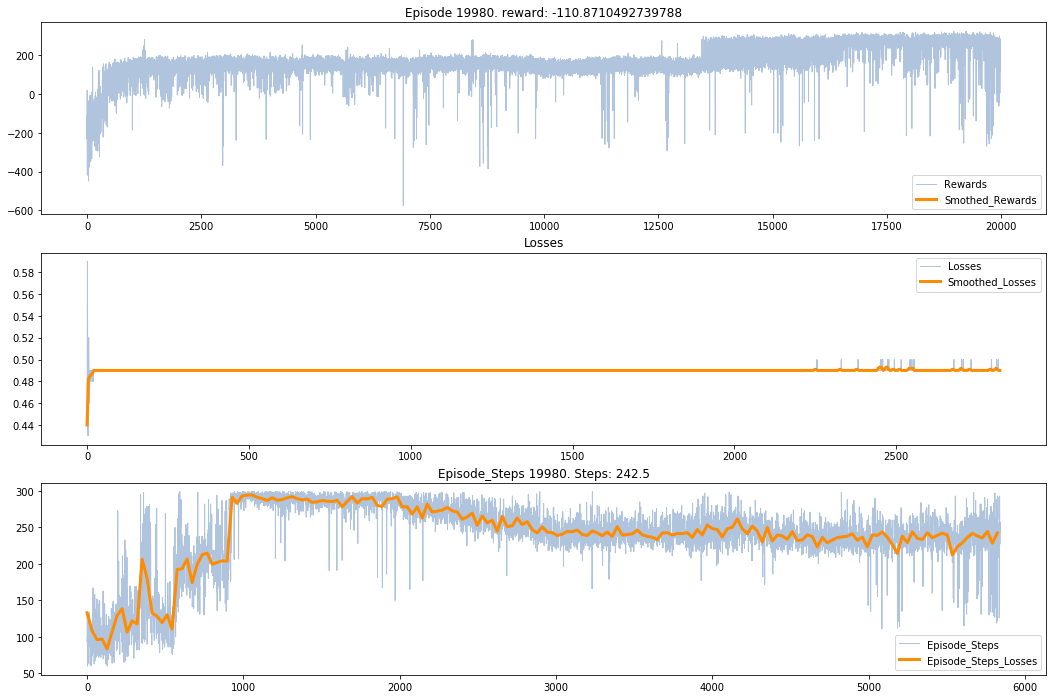

In [7]:
all_rewards, all_loss, episode_steps, timestep = [], [], [], 0

for epoch in range(max_epoch):
    
    state = env.reset()
    rewards = 0
    
    for i in range(num_timesteps):
        timestep += 1
        
        next_state, reward, done = choose_action(state)
        
        state = next_state
        rewards += reward
        
        if timestep % update_timestep == 0:
            loss = ppo_train(next_state)
            all_loss.append(loss)
            timestep = 0
        
        if done :
            episode_steps.append(i)
            break
    
    all_rewards.append(rewards)
    if epoch % 30 == 0:
        plot(epoch, all_rewards, all_loss, episode_steps)

In [8]:
torch.save(old_network.state_dict(), "./model/LunarLander-v2_PPO2.pth")

In [9]:
# env_name = "LunarLander-v2"
# env = gym.make(env_name)
# in_dim = env.observation_space.shape[0]
# out_dim = env.env.action_space.n
test_episodes = 100
test_steps = 300

def test_ppo():
    test_rewards = []
    # network = Actor_critic(in_dim, out_dim).to(device)
    # network.load_state_dict(torch.load("./model/LunarLander-v2_PPO2.pth"))
    for _ in range(test_episodes):
        state = env.reset()
        rewards = 0
        for _ in range(test_steps):
            state = torch.FloatTensor(state).to(device)
            with torch.no_grad():
                dist, value = old_network(state)
            action = dist.probs.argmax()
            next_state, reward, done, _ = env.step(action.item())
            state = next_state
            rewards += reward
            if done: break
            
        test_rewards.append(rewards)
    return test_rewards

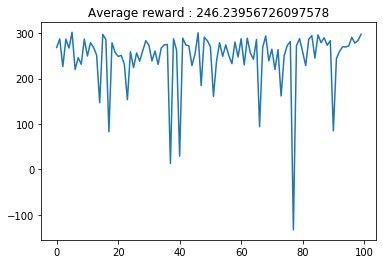

In [10]:
test_result = test_ppo()
plt.title("Average reward : {}".format(np.array(test_result).mean()))
plt.plot(test_result)

Reference:<br>
[https://github.com/nikhilbarhate99/PPO-PyTorch/blob/master/PPO.py](https://github.com/nikhilbarhate99/PPO-PyTorch/blob/master/PPO.py)<br>
[https://github.com/sweetice/Deep-reinforcement-learning-with-pytorch/tree/master/Char07%20PPO](https://github.com/sweetice/Deep-reinforcement-learning-with-pytorch/tree/master/Char07%20PPO)<br>